<a href="https://colab.research.google.com/github/ThomasMcDaniel91/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [2]:
# TODO - your code!
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind

#Loading in the dataframe and giving it the column headers
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [3]:
df = df.replace({'y': 1, 'n': 0, '?': np.NaN})
df.head()

repub = df[df['party'] == 'republican']
demo = df[df['party'] == 'democrat']
repub.head(20)
repub.shape

(168, 17)

In [0]:
## defining the function to show confidence interval

#assigning the parameters of data, and confidence while also assigning confidence
## it's value inside the parameters

def confidence_interval(data, confidence=0.95):
  #turns the data input into a numpy array
  data = data.dropna()
  #getting the mean of the data that has been input
  mean = np.mean(data)
  #setting our sample size to the length of the input
  n = len(data)
  #setting the standard deviation of the input data
  s = data.std()
  #formula for the standard error
  stderr = s / np.sqrt(n)
  #gets the t-statistic that includes 95% of the area under the curve for
  #the given amount of freedom represented by n - 1
  t = stats.t.ppf((1 + confidence) / 2, n-1)
  margin_of_error = t * stderr
  return (mean, mean - margin_of_error, mean + margin_of_error)

In [5]:
mean, lower, upper = confidence_interval(repub['el-salvador-aid'])
print(mean)
print(lower)
print(upper)

0.9515151515151515
0.91839794513717
0.9846323578931331


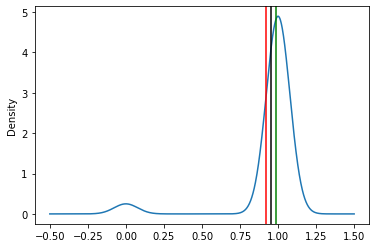

In [6]:
repub_graph = confidence_interval(repub['el-salvador-aid'])
repub['el-salvador-aid'].plot.density()
plt.axvline(x=repub_graph[0], color='black')
plt.axvline(x=repub_graph[1], color='red')
plt.axvline(x=repub_graph[2], color='green')
plt.show()

The graph tells me that with the provided sample size there is a 95% confidence level and a margin of error of 4% that being a republican means they will vote yes on this bill.

In [18]:
df2 = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df2.shape)
df2.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [19]:
#making sure this column is categorical
df2['race'].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [20]:
#making sure this column is categorical
df2['marital-status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [81]:
# Making my crosstab(also called contingency table) to begin the chi2 test
observed_frequencies = pd.crosstab(df2['race'], df2['marital-status'], margins=True)


observed_frequencies

marital-status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,All
race,,,,,,,,
Amer-Indian-Eskimo,60,0,116,9,103,11,12,311
Asian-Pac-Islander,75,0,508,41,372,19,24,1039
Black,485,1,837,62,1346,265,128,3124
Other,26,0,105,15,105,13,7,271
White,3797,22,13410,291,8757,717,822,27816
All,4443,23,14976,418,10683,1025,993,32561


In [82]:
observed = pd.crosstab(df2['race'], df2['marital-status'])

observed = observed.values

observed

array([[   60,     0,   116,     9,   103,    11,    12],
       [   75,     0,   508,    41,   372,    19,    24],
       [  485,     1,   837,    62,  1346,   265,   128],
       [   26,     0,   105,    15,   105,    13,     7],
       [ 3797,    22, 13410,   291,  8757,   717,   822]])

In [83]:
#Getting the sums of all the rows
row_sums = observed_frequencies.iloc[0:5, -1:].values
#Turns these values into a 1D array
row_sums = row_sums.T[0]

row_sums

array([  311,  1039,  3124,   271, 27816])

In [104]:
#Getting the sums of all the columns

col_sums = observed_frequencies.iloc[5:6, :-1].values
#Turns these values into a 1D array
#col_sums = col_sums.T[0]

col_sums = np.array(col_sums)
col_sums = col_sums.flatten()
col_sums

array([ 4443,    23, 14976,   418, 10683,  1025,   993])

In [105]:
#sets the total_samples variable to the value of i[0] of df.shape which is the
#total amount of entries in the dataframe
total_samples = df2.shape[0]

total_samples

32561

In [106]:
# Creating an empty list for the expected values to append to
expected_values = []

for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total_samples
    expected_row.append(expected_val)
  expected_values.append(expected_row)

expected_values = np.array(expected_values)
print(expected_values.shape)
print(expected_values)

(5, 7)
[[4.24364424e+01 2.19679985e-01 1.43040324e+02 3.99244495e+00
  1.02036578e+02 9.79008630e+00 9.48444458e+00]
 [1.41773195e+02 7.33914806e-01 4.77874267e+02 1.33381039e+01
  3.40887473e+02 3.27070729e+01 3.16859740e+01]
 [4.26274746e+02 2.20668898e+00 1.43684236e+03 4.01041737e+01
  1.02495906e+03 9.83415743e+01 9.52713983e+01]
 [3.69783790e+01 1.91425325e-01 1.24642855e+02 3.47894721e+00
  8.89129019e+01 8.53091121e+00 8.26458033e+00]
 [3.79553724e+03 1.96482909e+01 1.27936002e+04 3.57086330e+02
  9.12620399e+03 8.75630355e+02 8.48293603e+02]]


In [107]:
chi2 = ((observed - expected_values)**2 / expected_values).sum()
print(chi2)

923.8086971524608


In [108]:
chi2, p_value, dof, expected = stats.chi2_contingency(observed)
print(chi2)
print(p_value)
print(dof)
print(expected)

923.8086971524608
1.3087338193819433e-179
24
[[4.24364424e+01 2.19679985e-01 1.43040324e+02 3.99244495e+00
  1.02036578e+02 9.79008630e+00 9.48444458e+00]
 [1.41773195e+02 7.33914806e-01 4.77874267e+02 1.33381039e+01
  3.40887473e+02 3.27070729e+01 3.16859740e+01]
 [4.26274746e+02 2.20668898e+00 1.43684236e+03 4.01041737e+01
  1.02495906e+03 9.83415743e+01 9.52713983e+01]
 [3.69783790e+01 1.91425325e-01 1.24642855e+02 3.47894721e+00
  8.89129019e+01 8.53091121e+00 8.26458033e+00]
 [3.79553724e+03 1.96482909e+01 1.27936002e+04 3.57086330e+02
  9.12620399e+03 8.75630355e+02 8.48293603e+02]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)